# Tutorial 3: Solvation free energy of ethanol
## Background
- Free energy determines the direction of biological processes
- E.g. free energy decreases when molecule (ethanol) dissolve in solvent
- Binding free energy is used to investigate the binding affinity of ligands or drugs
- free energy difference between two states $A$ and $B$ ($F_B - F_A$) determines their relative probability $p_A$ and $p_B$,
$$ \frac{p_A}{p_B} = exp \frac{F_B - F_A}{k_BT}$$
- Types of free energy: Free energy of solvation, binding free energy ...

## Different methods to compute free energy 
### 1. Potential of mean force
- Concept: Calculating the integral of the force over the distance from the bound state to the completely unbound state. It applies a mechanical force to explore the energy landscape.
- Difficulty: Need to explore all possible states while ligand is pulled away, long convergence time
### 2. Alchemical free energy computation
- Free energy perturbation: Transition is split into several intermediate unphysical (alchemical) states, so that it is reversible to calculate BAR. The interaction strength between a molecule of interest and the rest of the system is coupled to a variable $\lambda$:
$$ E_{total} = E_{ligand-ligand} + E_{rest-rest} + \lambda E_{ligand-rest}  $$
and we slowly turn $\lambda$ from 1 (coupled) to 0 (decoupled)
    - Free energy of binding
        - Step 1: At $\lambda=0$, ligand is decoupled from solvent, corresponds to $\Delta G_1$
        - Step 2: Resolvate ligand in the presence of receeptor ($\Delta G_2$), reaching $\lambda=1$
    - Free energy of solvation
      - Resolvate ligand in the presence of solvent ($\Delta G_2$)
 - Bennett Acceptance Ratio (BAR): Use outputs of two simulations to calculate the Monte Carlo acceptance rates of transitions and estimate the free energy difference
 
## Tutorial overview
- Coulomb and van der Waals' interactions are turned off
- Use 'soft-core' interactions to make sure two point charges won't sit on top and cancels out the free energy difference
- Force field: OPLS
- Solute: SPC/E water
- Input files:

In [31]:
!ls input_files

ethanol_Sethane.top ethanol.gro         topol.top


In [35]:
!cat input_files/topol.top

; include the OPLS forcefield
#include "oplsaa.ff/forcefield.itp"

; add our own ethanol
[ moleculetype ]
; Name            nrexcl
ethanol	3

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
     1   opls_158      1   ETH      CB      1      0.145     12.011
     2   opls_140      1   ETH     HB1      1       0.06      1.008
     3   opls_140      1   ETH     HB2      1       0.06      1.008
     4   opls_154      1   ETH     OG1      1     -0.683    15.9994
     5   opls_155      1   ETH     HG1      1      0.418      1.008
     6   opls_135      1   ETH     CG2      2      -0.18     12.011
     7   opls_140      1   ETH    HG21      2       0.06      1.008
     8   opls_140      1   ETH    HG22      2       0.06      1.008
     9   opls_140      1   ETH    HG23      2       0.06      1.008

[ bonds ]
;  ai    aj funct            c0            c1            c2            c3
    1     2     1 
    1     3     1 
    1     4     

## Step 1: Prepare the system

In [ ]:
# Preparing the system

import os,shutil

#simple function to write mdp files
def write_mdp(mdp_string, mdp_name, directory):
    mdp_filename=os.path.join(directory,mdp_name)
    mdp_filehandle=open(mdp_filename,'w')
    mdp_filehandle.write(mdp_string)
    mdp_filehandle.close()

#get the path to the working directory
pwd=os.getcwd()

#path to gromacs files
input_files=os.path.join(pwd,'input_files')
output_files=os.path.join(pwd,'output_files')
if not os.path.isdir(output_files):
    os.mkdir(output_files)
shutil.copy(os.path.join(input_files,'ethanol.gro'),os.path.join(output_files,'ethanol.gro'))
shutil.copy(os.path.join(input_files,'topol.top'),os.path.join(output_files,'topol.top'))
%cd output_files

In [ ]:
!gmx editconf -f ethanol.gro -o box.gro -bt dodecahedron -d 1.2

In [ ]:
!gmx solvate -cp box.gro -cs -o solvated.gro -p topol.top

In [ ]:
em_mdp=""";minimal mdp options for energy minimization
integrator               = steep
nsteps                   = 500
coulombtype              = pme
"""
write_mdp(em_mdp,'em.mdp',output_files)
!gmx grompp -f em.mdp -c solvated.gro -o em.tpr
!gmx mdrun -v -deffnm em -ntmpi 1 -ntomp 1

In [ ]:
equil_mdp=""";equilibration mdp options
integrator               = md
nsteps                   = 100000
dt                       = 0.002
nstenergy                = 100
rlist                    = 1.1
nstlist                  = 10
rvdw                     = 1.1
coulombtype              = pme
rcoulomb                 = 1.1
fourierspacing           = 0.13
constraints              = h-bonds
tcoupl                   = v-rescale
tc-grps                  = system
tau-t                    = 0.5
ref-t                    = 300
pcoupl                   = C-rescale
ref-p                    = 1
compressibility          = 4.5e-5
tau-p                    = 1
gen-vel                  = yes
gen-temp                 = 300
"""
write_mdp(equil_mdp,'equil.mdp',output_files)
!gmx grompp -f equil.mdp -c em.gro -o equil.tpr
!gmx mdrun -deffnm equil -ntmpi 1 -ntomp 8

## Step 2: Creating the $\lambda$ points

- $\lambda = 0$: Decoupled
- $\lambda = 1$: Fully coupled
- $\lambda = 0.2,0.4, 0.6, 0.8, 0.9$: Intermediate states
- `sc` options: Soft-core interactions to prevent overlapping particles

In [ ]:
run_mdp="""; we'll use the sd integrator (an accurate and efficient leap-frog stochastic dynamics integrator) with 100000 time steps (200ps)
integrator               = sd
nsteps                   = 100000
dt                       = 0.002
nstenergy                = 1000
nstcalcenergy            = 50 ; should be a divisor of nstdhdl 
nstlog                   = 5000
; cut-offs at 1.0nm
rlist                    = 1.1
rvdw                     = 1.1
; Coulomb interactions
coulombtype              = pme
rcoulomb                 = 1.1
fourierspacing           = 0.13
; Constraints
constraints              = h-bonds
; set temperature to 300K
tc-grps                  = system
tau-t                    = 2.0
ref-t                    = 300
; set pressure to 1 bar with a thermostat that gives a correct
; thermodynamic ensemble
pcoupl                   = C-rescale
ref-p                    = 1.0
compressibility          = 4.5e-5
tau-p                    = 5.0

; and set the free energy parameters
free-energy              = yes
couple-moltype           = ethanol
nstdhdl                  = 50 ; frequency for writing energy difference in dhdl.xvg, 0 means no ouput, should be a multiple of nstcalcenergy. 
; these 'soft-core' parameters make sure we never get overlapping
; charges as lambda goes to 0
; soft-core function
sc-power                 = 1
sc-sigma                 = 0.3
sc-alpha                 = 1.0
; we still want the molecule to interact with itself at lambda=0
couple-intramol          = no
couple-lambda1           = vdwq
couple-lambda0           = none
init-lambda-state        = {}
; These are the lambda states at which we simulate
; for separate LJ and Coulomb decoupling, use
fep-lambdas              = 0.0 0.2 0.4 0.6 0.8 0.9 1.0
"""

# Step 3: Run simulation from solution to vaccum 

In [ ]:
number_of_lambdas=7
for lambda_number in range(number_of_lambdas):
    lambda_directory=os.path.join(output_files,'lambda_{:0>2}'.format(lambda_number))
    os.mkdir(lambda_directory)
    gro_file=os.path.join(output_files,'equil.gro')
    top_file=os.path.join(output_files,'topol.top')
    shutil.copy(gro_file,os.path.join(lambda_directory,'conf.gro'))
    shutil.copy(top_file,lambda_directory)
    write_mdp(run_mdp.format(lambda_number),'grompp.mdp',lambda_directory)
    %cd $lambda_directory
    !gmx grompp
    !gmx mdrun -ntmpi 1 -ntomp 8

## Step 4: Extracting the free energy for each alchemical state
1. Read energy file: `dhdl.xvg` (derivatives of Hamilton w.r.t. lambda at each step)
2. Use `gmx bar` tool
   - b 100: disregard first 100 ps (equilibration) 

In [ ]:
# Read energy file
!head -40 lambda_00/dhdl.xvg

In [78]:
# Calculate free energy difference using BAR
bar_string = ''
for lambda_number in range(number_of_lambdas):
    lambda_directory=os.path.join(output_files,'lambda_{:0>2}'.format(lambda_number))
    bar_string=bar_string + lambda_directory + '/dhdl.xvg '
!gmx bar -b 100 -f $bar_string

                   :-) GROMACS - gmx bar, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3
Command line:
  gmx bar -b 100 -f /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_00/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_01/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_02/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_03/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_04/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_05/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_06/dhdl.xvg

/Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files/lambda_00/dhdl.xvg: Ignoring set '

## Step 5: Relative free energy of solvation

By modifying the mdp file, we investigate the relative free energies from ethanol (type) to ethanethiol (typeB) in water. (Ehtanol was fixed originally) 

In [46]:
!pwd

/Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3


In [50]:
!sed -n 10p input_files/ethanol_Sethane.top 
!diff --color input_files/topol.top input_files/ethanol_Sethane.top 

;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
11c11
<      1   opls_158      1   ETH      CB      1      0.145     12.011
---
>      1   opls_158      1   ETH      CB      1      0.145     12.011   opls_206    0.06 12.011
14,15c14,15
<      4   opls_154      1   ETH     OG1      1     -0.683    15.9994
<      5   opls_155      1   ETH     HG1      1      0.418      1.008
---
>      4   opls_154      1   ETH     OG1      1     -0.683    15.9994   opls_200  -0.335  32.06
>      5   opls_155      1   ETH     HG1      1      0.418      1.008   opls_204   0.155  1.008


In [ ]:
run_rel_mdp="""; we'll use the sd integrator (an accurate and efficient leap-frog stochastic dynamics integrator) with 100000 time steps (200ps)
integrator               = sd
nsteps                   = 100000
dt                       = 0.002
nstenergy                = 1000
nstcalcenergy            = 50 ; should be a divisor of nstdhdl 
nstlog                   = 5000
; cut-offs at 1.0nm
rlist                    = 1.1
rvdw                     = 1.1
; Coulomb interactions
coulombtype              = pme
rcoulomb                 = 1.1
fourierspacing           = 0.13
; Constraints
constraints              = h-bonds
; set temperature to 300K
tc-grps                  = system
tau-t                    = 2.0
ref-t                    = 300
; set pressure to 1 bar with a thermostat that gives a correct
; thermodynamic ensemble
pcoupl                   = C-rescale
ref-p                    = 1.0
compressibility          = 4.5e-5
tau-p                    = 5.0

; and set the free energy parameters
free-energy              = yes
nstdhdl                  = 50 ; frequency for writing energy difference in dhdl.xvg, 0 means no ouput, should be a multiple of nstcalcenergy. 
; these 'soft-core' parameters make sure we never get overlapping
; charges as lambda goes to 0
; soft-core function
sc-power                 = 1
sc-sigma                 = 0.3
sc-alpha                 = 1.0
; we still want the molecule to interact with itself at lambda=0
init-lambda-state        = {}
; These are the lambda states at which we simulate
; for separate LJ and Coulomb decoupling, use
fep-lambdas              = 0.0 0.2 0.4 0.6 0.8 0.9 1.0
"""

#### Exercise: Following the procedure described in this tutorial, calculate the relative free energy for the transformation from ethanol to ethanethiol in water solution. Based on your results, which molecule is more hydrophilic?   
*Tip: use different paths or input/output names for the different calculations to avoid overwriting your previous results.*

In [ ]:
import os,shutil
output_files_1='/Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise'

In [ ]:
number_of_lambdas=7
for lambda_number in range(number_of_lambdas):
    lambda_directory=os.path.join(output_files_1,'lambda_{:0>2}'.format(lambda_number))
    os.mkdir(lambda_directory)
    gro_file=os.path.join(output_files_1,'ethanol_Sethane.gro')
    top_file=os.path.join(output_files_1,'ethanol_Sethane.top')
    shutil.copy(gro_file,os.path.join(lambda_directory,'conf.gro'))
    shutil.copy(top_file,lambda_directory)
    write_mdp(run_rel_mdp.format(lambda_number),'grompp.mdp',lambda_directory)
    %cd $lambda_directory
    !gmx grompp -p ethanol_Sethane.top 
    !gmx mdrun -v -ntmpi 1 -ntomp 8 

In [80]:
!pwd

/Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3


In [82]:
# Calculate free energy difference using BAR
bar_string = ''
for lambda_number in range(number_of_lambdas):
    lambda_directory=os.path.join(output_files_1,'lambda_{:0>2}'.format(lambda_number))
    bar_string=bar_string + lambda_directory + '/dhdl.xvg '
!gmx bar -b 100 -f $bar_string -o -oi -oh

                   :-) GROMACS - gmx bar, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3
Command line:
  gmx bar -b 100 -f /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise/lambda_00/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise/lambda_01/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise/lambda_02/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise/lambda_03/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise/lambda_04/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise/lambda_05/dhdl.xvg /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-3/output_files_exercise/lambda_06/dhdl.xvg -o -oi -oh

/Users/heiley/Desktop/SURP/g

Result: 25.07 kJ mol^{-1}

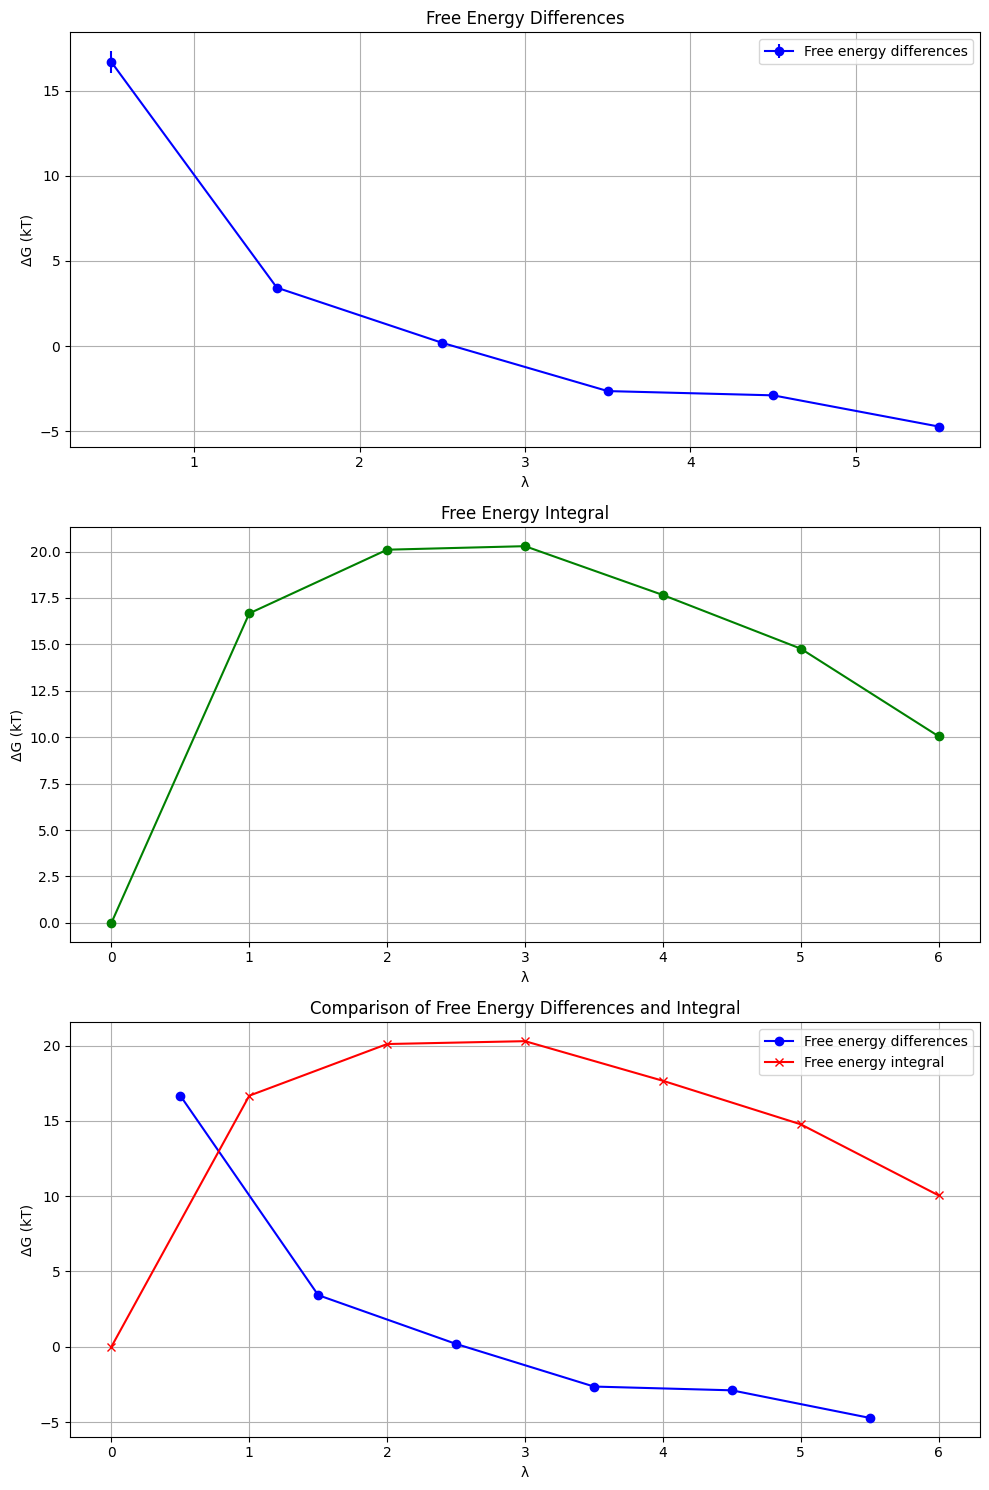

In [89]:
import matplotlib.pyplot as plt

# Data from bar.xvg
x_bar = [0.500, 1.500, 2.500, 3.500, 4.500, 5.500]
y_bar = [16.67, 3.43, 0.19, -2.64, -2.89, -4.72]
dy_bar = [0.64, 0.09, 0.10, 0.05, 0.04, 0.08]

# Data from barint.xvg
x_barint = [0, 1, 2, 3, 4, 5, 6]
y_barint = [0.00, 16.67, 20.10, 20.29, 17.66, 14.77, 10.05]

# Creating subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for bar.xvg
axs[0].errorbar(x_bar, y_bar, yerr=dy_bar, fmt='o-', label='Free energy differences', color='b')
axs[0].set_title("Free Energy Differences")
axs[0].set_xlabel("λ")
axs[0].set_ylabel("ΔG (kT)")
axs[0].grid()
axs[0].legend()

# Plot for barint.xvg
axs[1].plot(x_barint, y_barint, marker='o', linestyle='-', color='g')
axs[1].set_title("Free Energy Integral")
axs[1].set_xlabel("λ")
axs[1].set_ylabel("ΔG (kT)")
axs[1].grid()

# Plotting all data (optional)
axs[2].plot(x_bar, y_bar, marker='o', linestyle='-', label='Free energy differences', color='b')
axs[2].plot(x_barint, y_barint, marker='x', linestyle='-', label='Free energy integral', color='r')
axs[2].set_title("Comparison of Free Energy Differences and Integral")
axs[2].set_xlabel("λ")
axs[2].set_ylabel("ΔG (kT)")
axs[2].grid()
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

#### Compare the mdp parameters for alchemical transformation to those used to compute the free energy of solvation
Parameters removed from alchemical transformation mdp file:
- couple-moltype           = ethanol
  - (Specifies the molecule type being altered during the transformation. Removing this means that the particular molecule being transformed (ethanol) is no longer explicitly defined in the setup for the alchemical process.)
- couple-intramol          = no
  - (Specifies whether intermolecular interactions are included in coupling. Removing this means the decoupled state is not in vacuum state)
- couple-lambda1           = vdwq
  - (Specifies which interactions are scaled at the final state. Removing this means vdW is not explicitly coupled)
- couple-lambda0           = none
  - (Specifies which interactions are scaled at the initial state. Removing this means vdW interactions are not turned off and soft-core interactions are not used.)

In [17]:
!diff --color grompp.mdp ../../output_files/lambda_00/grompp.mdp 

29a30
> couple-moltype           = ethanol
38c39,42
< init-lambda-state        = 6
---
> couple-intramol          = no
> couple-lambda1           = vdwq
> couple-lambda0           = none
> init-lambda-state        = 0


Where to go from here
After calculating the free energy of solvation, we’ve solved the first part of the free energy of binding of the earlier equations. The second part involves coupling a molecule into (or out of) a situation where it is bound to a protein. This introduces one additional complexity: we end up with a situation where a weakly coupled ligand wanders through our system: weak-couple.png which is bad because this is a poorly reversible situation: there are suddenly very few states that map from a weakly coupled to a more strongly coupled molecule, which will drastically reduce the accuracy of the free energy calculation.

This situation can be remedied by forcing the ligand to stay at a specific position relative to the protein. This can be done with the GROMACS ‘pull code’, which allows the specification of arbitrary forces or constraints onto with respect to centers of mass of any chosen set of atoms onto any other group of atoms. With a pull type of ‘umbrella’, we can specify that we want a quadratic potential to this specified location, forcing the ligand to stay at its native position even when it has been fully de-coupled.

One way find out where to put the center of the force is by choosing a group of atoms in the protein close to the ligand, and doing a simulation with full ligand coupling, where the pull code is enabled, but with zero force. The pull code will then frequently output the coordinates of the ligand, from which an average position and an expected deviation can be calculated. This can then serve as a reference point for the location of the center of force for the pull code during the production runs, and the force constant of the pull code.

Once the free energy has been calculated, care must be taken to correct for the fact that we have trapped our molecule. This can easily be done analytically.

Optional Question: Given a measured standard deviation in the location of the center of mass of our ligand, how do we choose the force constant for the pull code?

Optional Question: How do we correct for using the pull code: what is the contribution to the free energy of applying a quadratic potential to a molecule?